# Variational Autoencoder

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
import matplotlib.pyplot as plt
%matplotlib inline

/home/huckleberry/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mnist = read_data_sets('./fashion-mnist/data/fashion', one_hot=True)
n_samples = mnist.train.num_examples

Extracting ./fashion-mnist/data/fashion/train-images-idx3-ubyte.gz
Extracting ./fashion-mnist/data/fashion/train-labels-idx1-ubyte.gz
Extracting ./fashion-mnist/data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./fashion-mnist/data/fashion/t10k-labels-idx1-ubyte.gz


## Task: fill the gaps in VAE 

In [54]:
class VAE:
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus,
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])

        self._create_network()
        self._create_loss_optimizer()

        init = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession(config = tf.ConfigProto(device_count = {'GPU': 1}, log_device_placement=True))
        self.sess.run(init)

    def _create_network(self):
        # Use recognition network to determine mean and
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = self._recognition_network()

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        # tip: use tf.random_normal
        eps = tf.random_normal(shape=[n_z])

        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean,
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = self._generator_network()

    def _recognition_network(self):
        with tf.device('gpu:0'):
            layer_1 = slim.fully_connected(self.x, self.network_architecture['n_hidden_recog_1'])
            layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'])

            z_mean = slim.fully_connected(layer_2, self.network_architecture['n_z'])
            z_log_sigma_sq = slim.fully_connected(layer_2, self.network_architecture['n_z'])

            return z_mean, z_log_sigma_sq

    def _generator_network(self):
        with tf.device('gpu:0'):
            layer_1 = slim.fully_connected(self.z, self.network_architecture['n_hidden_recog_1'])
            layer_2 = slim.fully_connected(layer_1, self.network_architecture['n_hidden_recog_2'])
            x_reconstr_mean = slim.fully_connected(layer_2, self.network_architecture['n_input'])

            return x_reconstr_mean

    def _create_loss_optimizer(self):

        reconstr_loss = tf.nn.l2_loss(self.x - self.x_reconstr_mean)

        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)

        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)  # average over batch
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

    def partial_fit(self, X):
        """Train model based on mini-batch of input data.

        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost),
                                  feed_dict={self.x: X})
        return cost

    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})

    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.

        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent
        space.
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.z: z_mu})

    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean,
                             feed_dict={self.x: X})


In [55]:
def train(network_architecture, learning_rate=0.001,
          batch_size=1000, training_epochs=10, display_step=5):
    vae = VAE(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size

        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), 
                  "cost=", "{:.9f}".format(avg_cost))
    return vae

In [56]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15830270933864577256
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 157220864
locality {
  bus_id: 1
}
incarnation: 7394243393303325929
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Visualize reconstruction quality

In [57]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=20)  # dimensionality of latent space

vae = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 39726.805220170
Epoch: 0006 cost= 16032.078568892
Epoch: 0011 cost= 12576.565962358
Epoch: 0016 cost= 11084.632315341
Epoch: 0021 cost= 10172.536097301
Epoch: 0026 cost= 9722.866725852
Epoch: 0031 cost= 9161.911487926
Epoch: 0036 cost= 8905.020454545
Epoch: 0041 cost= 8408.868794389
Epoch: 0046 cost= 8270.285440341
Epoch: 0051 cost= 7957.796608665
Epoch: 0056 cost= 7662.212926136
Epoch: 0061 cost= 7826.596218040
Epoch: 0066 cost= 7555.353364702
Epoch: 0071 cost= 7306.468181818


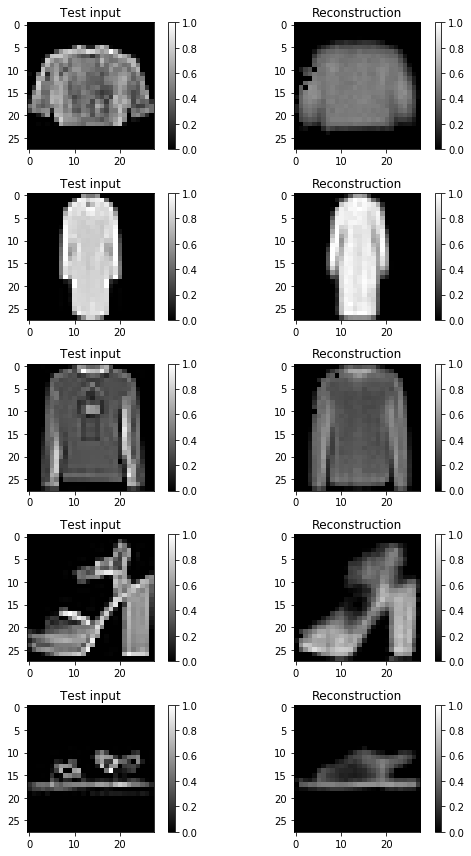

In [58]:
x_sample = mnist.test.next_batch(1000)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

## Illustrating latent space

Next, we train a VAE with 2d latent space and illustrates how the encoder (the recognition network) encodes some of the labeled inputs (collapsing the Gaussian distribution in latent space to its mean). This gives us some insights into the structure of the learned manifold (latent space)

In [59]:
network_architecture = \
    dict(n_hidden_recog_1=500, # 1st layer encoder neurons
         n_hidden_recog_2=500, # 2nd layer encoder neurons
         n_hidden_gener_1=500, # 1st layer decoder neurons
         n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)

Epoch: 0001 cost= 39649.929723011
Epoch: 0006 cost= 28089.047230114
Epoch: 0011 cost= 26893.345134943
Epoch: 0016 cost= 26804.067649148
Epoch: 0021 cost= 26068.670738636
Epoch: 0026 cost= 25736.732386364
Epoch: 0031 cost= 19245.288849432
Epoch: 0036 cost= 17897.393430398
Epoch: 0041 cost= 17272.502823153
Epoch: 0046 cost= 17108.150887784
Epoch: 0051 cost= 16512.361772017
Epoch: 0056 cost= 16346.274928977
Epoch: 0061 cost= 16170.275656960
Epoch: 0066 cost= 15761.600337358
Epoch: 0071 cost= 15746.339524148


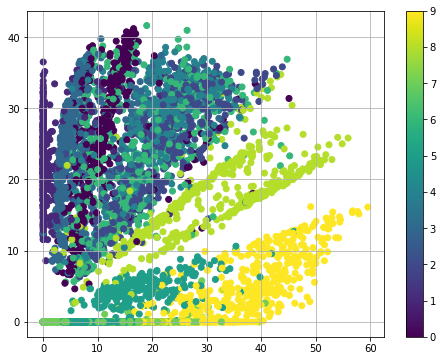

In [67]:
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

An other way of getting insights into the latent space is to use the generator network to plot reconstrunctions at the positions in the latent space for which they have been generated:

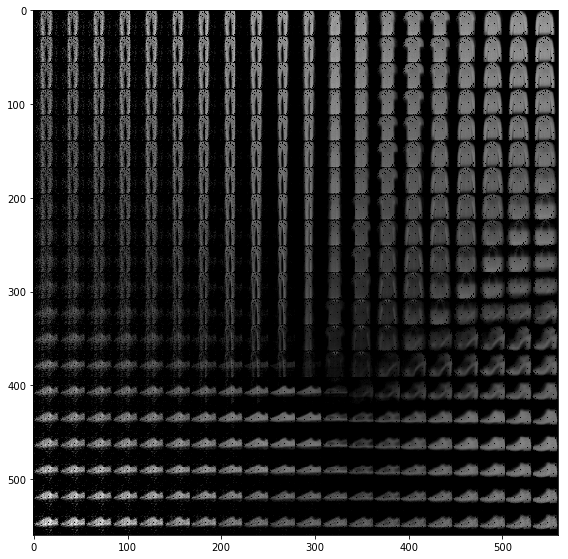

In [72]:
nx = ny = 20
x_values = np.linspace(-10, 40, nx)
y_values = np.linspace(-30, 30, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()